In [ ]:
!pip install catboost

In [ ]:
import pandas as pd

In [ ]:
df  = pd.read_csv("train.csv")

In [ ]:
df.head()

,line_id,summary,question,answer,is_hallucination
0,0,Херманус Питер (Дик) Логгере (нидерл. Hermanus...,В каком городе проходил чемпионат мира по хокк...,В Хилверсюме.,1
1,1,Ходуткинские горячие источники (Худутские горя...,Как называется район в который входят источники?,Елизовским районом,0
2,2,Чёрная вдова (лат. Latrodectus mactans) — вид ...,Для кого опасны пауки-бокоходы?,Для рыб.,1
3,3,"Рысь — река в России, протекает по территориям...",Какова длина реки Рысь?,5 км.,1
4,4,"И́се (яп. 伊勢市), ранее Удзиямада — город в Япон...",Что такое Исе?,"Исе — это небольшой город в Японии, который не...",1


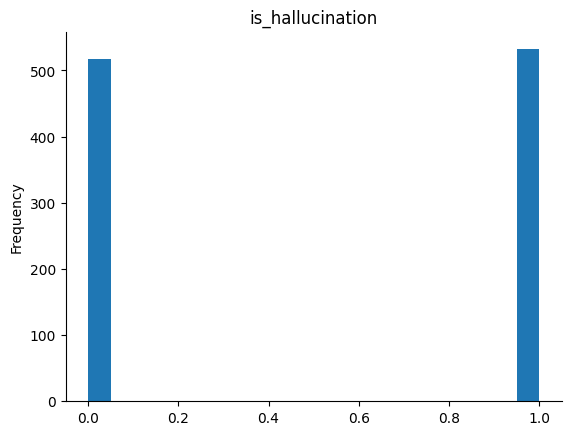

In [ ]:
# @title is_hallucination

from matplotlib import pyplot as plt
df['is_hallucination'].plot(kind='hist', bins=20, title='is_hallucination')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df.describe()

,line_id,is_hallucination
count,1050.000000,1050.000000
mean,524.500000,0.506667
std,303.253195,0.500194
min,0.000000,0.000000
25%,262.250000,0.000000
50%,524.500000,1.000000
75%,786.750000,1.000000
max,1049.000000,1.000000


In [ ]:
def fill_na(df, features):
    for feature in features:
        df[feature] = df[feature].fillna('')

In [ ]:
content_dir = "/content"
text_features = ['summary', 'question', 'answer']
column_name = "is_hallucination"
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

df = df.drop(["line_id"], axis=1)
fill_na(df, text_features)
# Разделение данных на тренировочный и валидационный наборы
train, valid = train_test_split(
    df,
    train_size=0.7,
    random_state=0,
    stratify=df[column_name]
)

# Разделение на признаки и целевую переменную для тренировочного набора
X_train = train.drop([column_name], axis=1)
y_train = train[column_name]

# Разделение на признаки и целевую переменную для валидационного набора
X_valid = valid.drop([column_name], axis=1)
y_valid = valid[column_name]

# Кодирование целевой переменной в категориальный формат для тренировочного набора
y_train_c = tf.keras.utils.to_categorical(
    y_train.astype('category').cat.codes.values, num_classes=2
)

# Кодирование целевой переменной в категориальный формат для валидационного набора
y_valid_c = tf.keras.utils.to_categorical(
    y_valid.astype('category').cat.codes.values, num_classes=2
)

In [ ]:
df.head()

,summary,question,answer,is_hallucination
0,Херманус Питер (Дик) Логгере (нидерл. Hermanus...,В каком городе проходил чемпионат мира по хокк...,В Хилверсюме.,1
1,Ходуткинские горячие источники (Худутские горя...,Как называется район в который входят источники?,Елизовским районом,0
2,Чёрная вдова (лат. Latrodectus mactans) — вид ...,Для кого опасны пауки-бокоходы?,Для рыб.,1
3,"Рысь — река в России, протекает по территориям...",Какова длина реки Рысь?,5 км.,1
4,"И́се (яп. 伊勢市), ранее Удзиямада — город в Япон...",Что такое Исе?,"Исе — это небольшой город в Японии, который не...",1


In [ ]:
from catboost import CatBoostClassifier, Pool, MetricVisualizer
def fit_model(train_pool, test_pool, **kwargs):
    model = CatBoostClassifier(
        task_type='GPU',
        iterations=1000,
        depth=6,
        eval_metric='Accuracy',
        od_type='Iter',
        od_wait=500,
        **kwargs
    )
    return model.fit(
        train_pool,
        eval_set=test_pool,
        verbose=100,
        plot=True,
        plot_file=f"{content_dir}/fit_plot",

        use_best_model=True)

In [ ]:
train_pool = Pool(
    data=X_train,
    label=y_train,
    text_features=text_features
)

valid_pool = Pool(
    data=X_valid,
    label=y_valid,
    text_features=text_features
)

test_pool = Pool(
    data=df[[c for c in df.columns if c!=column_name]][text_features],
    label=df[column_name],
    text_features=text_features
)


In [ ]:
model = fit_model(
    train_pool, valid_pool,
    learning_rate=0.35,
    tokenizers=[
        {
            'tokenizer_id': 'Sense',
            'separator_type': 'BySense',
            'lowercasing': 'True',
            'token_types':['Word', 'Number', 'SentenceBreak'],
            'sub_tokens_policy':'SeveralTokens'
        }
    ],
    dictionaries = [
        {
            'dictionary_id': 'Word',
            'max_dictionary_size': '50000'
        }
    ],
    feature_calcers = [
        'BoW:top_tokens_count=10000'
    ]
)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6340136	test: 0.6539683	best: 0.6539683 (0)	total: 53.9ms	remaining: 53.8s
100:	learn: 0.9768707	test: 0.5682540	best: 0.6539683 (0)	total: 2.78s	remaining: 24.7s
200:	learn: 0.9986395	test: 0.6031746	best: 0.6539683 (0)	total: 5.35s	remaining: 21.3s
300:	learn: 1.0000000	test: 0.5968254	best: 0.6539683 (0)	total: 7.93s	remaining: 18.4s
400:	learn: 1.0000000	test: 0.6126984	best: 0.6539683 (0)	total: 12.2s	remaining: 18.2s
500:	learn: 1.0000000	test: 0.6063492	best: 0.6539683 (0)	total: 15.2s	remaining: 15.1s
bestTest = 0.653968254
bestIteration = 0
Shrink model to first 1 iterations.


KeyboardInterrupt: 